In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import Xception, xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2

print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-05-21 09:08:31.541393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 09:08:31.963126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.12.0
Num GPUs Available:  1


2023-05-21 09:08:32.390783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 09:08:32.402281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 09:08:32.402578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Create Datasets

In [3]:
# Load Directories
train_directory = "/home/luke/datasets/train-10"
test_directory = "/media/luke/System Storage/Deepfake Dataset/FF++/combine/test"

def create_train_val_datasets(
    input_dir,
    output_dir="data/datasets",
    img_height=299,
    img_width=299,
    batch_size=32,
    save_dataset=False,
    augment_training_data=False
):
    """
    Creates train and validation datasets from images in the input directory.

    Args:
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories.
        output_dir (str): The directory where the TFRecord files will be saved. Default is 'data/datasets'.
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
        save_dataset (bool): Whether to save the datasets as TFRecord files. Default is True.

    Returns:
        tf.data.Dataset, tf.data.Dataset: The train and validation datasets.
    """
    # Create ImageDataGenerator with validation split
    if augment_training_data:
        datagenTrain = ImageDataGenerator(
                    preprocessing_function=xception.preprocess_input,
                    rotation_range=20,  # Increased rotation range
                    width_shift_range=0.2,  # Increased shift range
                    height_shift_range=0.2,  # Increased shift range
                    shear_range=0.2,  # Increased shear range
                    zoom_range=0.2,  # Increased zoom range
                    horizontal_flip=True,
                    fill_mode="nearest",
                    validation_split=0.2
        )
    else:
        datagenTrain = ImageDataGenerator(
                    preprocessing_function=xception.preprocess_input,
                    validation_split=0.2
        )
        
    datagenVal = ImageDataGenerator(
                preprocessing_function=xception.preprocess_input,
                validation_split=0.2
    )   

        
    
    # Create a train and validation data generator
    train_gen = datagenTrain.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        shuffle=True
    )

    val_gen = datagenVal.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",
        shuffle=True
    )
    
    # Save the dataset if requested
    if save_dataset:
        train_filename = generate_filename("train_ds")
        val_filename = generate_filename("val_ds")
        tf.data.Dataset.save(train_gen, f"{output_dir}/{train_filename}.tfrecords")
        tf.data.Dataset.save(val_gen, f"{output_dir}/{val_filename}.tfrecords")
    
    return train_gen, val_gen

def create_test_dataset(
    input_dir,
    output_dir="data/datasets",
    img_height=299,
    img_width=299,
    batch_size=32,
    save_dataset=False,
):
    """
    Creates a test dataset from images in the input directory.

    Args:
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories.
        output_dir (str): The directory where the TFRecord file will be saved. Default is 'data/datasets'.
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
        save_dataset (bool): Whether to save the dataset as a TFRecord file. Default is True.

    Returns:
        tf.data.Dataset: The test dataset.
    """
    # Create ImageDataGenerator
    datagen = ImageDataGenerator(
        preprocessing_function=xception.preprocess_input
    )

    # Load all images
    test_gen = datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True
    )
    
    if save_dataset:
        filename = generate_filename("test_ds")
        tf.data.Dataset.save(test_gen, f"{output_dir}/{filename}.tfrecords")

    return test_gen

train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=False)
test_ds = create_test_dataset(test_directory, batch_size=32)

Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.


# Visualize Data

[0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

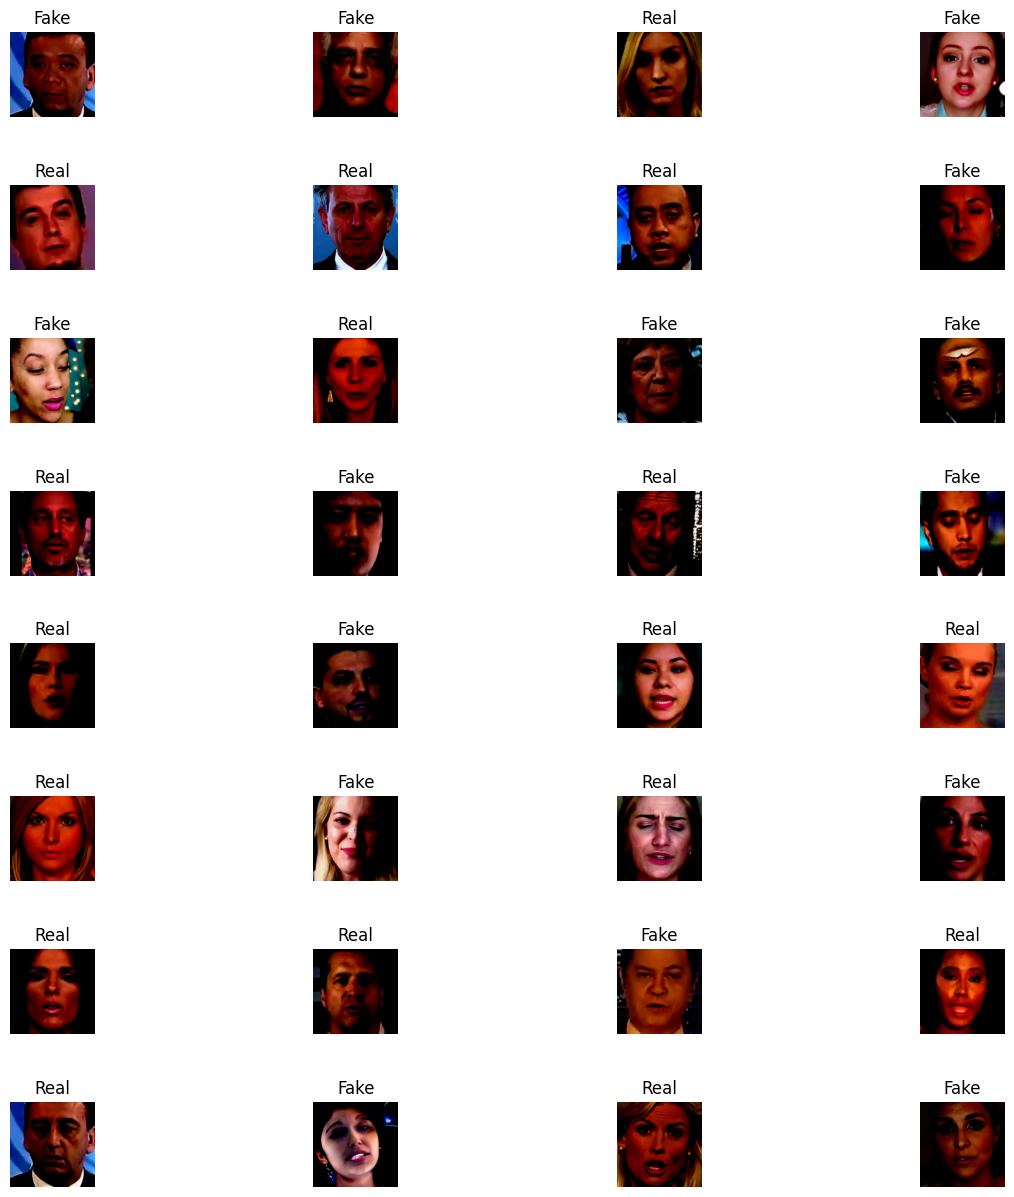

In [4]:
# Import first 32 images (first batch)
train_images, train_labels = next(train_ds)
print(train_labels)

# Redefine labels
label_names = {0: 'Fake', 1: 'Real'}

# Show some of our samples
# Define length and width of our figure
L = 8
W = 4

fig, axes = plt.subplots(L, W, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[train_labels[i]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.8)

# Building and Visualizing base model

In [5]:
# Create the base model from the pre-trained model Xception
base_model = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(299, 299, 3)))

# Freeze the base model (do not train everything but last 23 layers)
for layer in base_model.layers[:-23]:
    layer.trainable = False
    

2023-05-21 09:10:25.882839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 09:10:25.883192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 09:10:25.883476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# View model summary
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

# Data Augmentation

# **ID:001** Training the Model (1 Fully Connected Layer)

In [19]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=False)
test_ds = create_test_dataset(test_directory, batch_size=32)

# Define callbacks
# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 5
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.5,
    patience = 2, 
    min_lr = 1e-15 
)

# Save the model after every epoch
model_checkpoint = ModelCheckpoint(
    'models/001/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation = 'relu')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-3),  
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    epochs=50, 
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, reduce_lr]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/50


2023-05-20 16:03:24.116176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.4978 - binary_accuracy: 0.7444

2023-05-20 16:04:02.454280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - 45s 136ms/step - loss: 0.4978 - binary_accuracy: 0.7444 - val_loss: 0.8364 - val_binary_accuracy: 0.7154 - lr: 0.0010
Epoch 2/50
301/301 [==============================] - 41s 135ms/step - loss: 0.2642 - binary_accuracy: 0.8904 - val_loss: 1.6212 - val_binary_accuracy: 0.6525 - lr: 0.0010
Epoch 3/50
301/301 [==============================] - 41s 135ms/step - loss: 0.1561 - binary_accuracy: 0.9389 - val_loss: 0.8716 - val_binary_accuracy: 0.7750 - lr: 0.0010
Epoch 4/50
301/301 [==============================] - 41s 135ms/step - loss: 0.0687 - binary_accuracy: 0.9747 - val_loss: 0.7597 - val_binary_accuracy: 0.7912 - lr: 5.0000e-04
Epoch 5/50
301/301 [==============================] - 41s 135ms/step - loss: 0.0377 - binary_accuracy: 0.9858 - val_loss: 2.4777 - val_binary_accuracy: 0.6150 - lr: 5.0000e-04
Epoch 6/50
301/301 [==============================] - 41s 135ms/step - loss: 0.0326 - binary_accuracy: 0.9885 - val_loss: 1.0690 - val_binary_a

2023-05-20 16:09:33.563671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


134/134 [==============================] - 11s 81ms/step - loss: 0.6548 - binary_accuracy: 0.8694
Test Loss: 0.6548051238059998
Test Accuracy: 0.8693619966506958


# **ID:002** Training the Model (1 Fully Connected Layer with Augmented Data)

In [37]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/002/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(3070, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.7)(top_model)  # Increased dropout rate
top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Changed Neruons to 2048 for 1024
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Added bottom two layers
top_model = Dropout(0.2)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,  # Increased number of epochs
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/100


2023-05-20 22:01:20.815341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 1.8889 - binary_accuracy: 0.8991

2023-05-20 22:04:42.164704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.42028, saving model to models/002/best_model.h5
603/603 [==============================] - 216s 351ms/step - loss: 1.8889 - binary_accuracy: 0.8991 - val_loss: 1.4203 - val_binary_accuracy: 0.8285 - lr: 1.0000e-04
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 0.9821 - binary_accuracy: 0.9153
Epoch 2: val_loss improved from 1.42028 to 1.01741, saving model to models/002/best_model.h5
603/603 [==============================] - 210s 348ms/step - loss: 0.9821 - binary_accuracy: 0.9153 - val_loss: 1.0174 - val_binary_accuracy: 0.8413 - lr: 1.0000e-04
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.6441 - binary_accuracy: 0.9271
Epoch 3: val_loss improved from 1.01741 to 0.82751, saving model to models/002/best_model.h5
603/603 [==============================] - 206s 341ms/step - loss: 0.6441 - binary_accuracy: 0.9271 - val_loss: 0.8275 - val_binary_accuracy: 0.8304 - lr: 1.0000e-04
Epoch 4/100
603/60

## Test The Model

In [38]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


   1/1338 [..............................] - ETA: 3:40 - loss: 0.1387 - binary_accuracy: 0.9375

2023-05-20 23:07:36.579855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1338/1338 [==============================] - 110s 82ms/step - loss: 0.3778 - binary_accuracy: 0.8977
Test Loss: 0.37775301933288574
Test Accuracy: 0.8977001905441284


# **ID:002-H** Training the Model (Same as ID:002 with but with hypertuning)

In [7]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Define parameter possibilities as lists
optimizer = ['SGD', 'Adam', 'RMSprop', 'Nadam', 'Adagrad']

# Create list with accuracy score
accuracy_test = []

for opt in optimizer:
    
    model_checkpoint = ModelCheckpoint(
    f'models/002-H/{opt}/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
    )

    # Train Model
    # Define top_model which I will connect with base_model

    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(3070, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
    top_model = Dropout(0.7)(top_model)  # Increased dropout rate
    top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Changed Neruons to 2048 for 1024
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Added bottom two layers
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1, activation = 'sigmoid')(top_model)

    # Group the base_model and new fully-connected layers into a Model object
    model = Model(inputs = base_model.input, outputs = top_model)

    model.compile(
        optimizer=opt,
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy()],
    )

    if opt == 'Adam':
        koptimizer = Adam(learning_rate = 1e-4)
    elif opt == 'Nadam':
        koptimizer = Nadam(learning_rate = 1e-4)
    elif opt == 'RMSprop':
        koptimizer = RMSprop(learning_rate = 1e-4)
    elif opt == 'SGD':
        koptimizer = SGD(learning_rate = 1e-4, momentum = 0.9)
    elif opt == 'Adagrad':
        koptimizer = Adagrad(learning_rate = 1e-4)
    else:
        print('Unknown optimizer type')
        
    history = model.fit(
        train_ds, 
        steps_per_epoch = train_ds.samples // train_ds.batch_size,
        epochs=100,  # Increased number of epochs
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint]
    )
    
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    accuracy_test.append({
        'optimizer': opt,
        'test_accuracy': round(evaluate[1], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history['binary_accuracy'][-1],3),
        'train_loss': round(history.history['loss'][-1],3),
        'val_accuracy': round(history.history['val_binary_accuracy'][-1],3),
        'val_loss': round(history.history['val_loss'][-1],3)
    })

# Create DataFrame with accuracy score
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results = accuracy_test_results.sort_values(by = 'test_accuracy', ascending = False)

Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/100


2023-05-21 09:15:13.011010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 09:15:15.781317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-21 09:15:18.232950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-21 09:15:18.246710: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ef95fa09680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 09:15:18.246721: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-05-21 09:15:18.36330

603/603 [==============================] - ETA: 0s - loss: 3.9324 - binary_accuracy: 0.5105

2023-05-21 09:18:40.537444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.91964, saving model to models/002-H/SGD/best_model.h5
603/603 [==============================] - 222s 356ms/step - loss: 3.9324 - binary_accuracy: 0.5105 - val_loss: 3.9196 - val_binary_accuracy: 0.5146 - lr: 0.0100
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 3.9112 - binary_accuracy: 0.5260
Epoch 2: val_loss improved from 3.91964 to 3.90066, saving model to models/002-H/SGD/best_model.h5
603/603 [==============================] - 206s 341ms/step - loss: 3.9112 - binary_accuracy: 0.5260 - val_loss: 3.9007 - val_binary_accuracy: 0.5173 - lr: 0.0100
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 3.8910 - binary_accuracy: 0.5361
Epoch 3: val_loss improved from 3.90066 to 3.88014, saving model to models/002-H/SGD/best_model.h5
603/603 [==============================] - 207s 343ms/step - loss: 3.8910 - binary_accuracy: 0.5361 - val_loss: 3.8801 - val_binary_accuracy: 0.5385 - lr: 0.0100
Epoch 4/100


2023-05-21 11:09:58.840997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 122s 91ms/step - loss: 3.3284 - binary_accuracy: 0.8602
Epoch 1/100


2023-05-21 11:12:01.391478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 11:12:03.720063: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


603/603 [==============================] - ETA: 0s - loss: 1.0983 - binary_accuracy: 0.8032

2023-05-21 11:15:21.212202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.43517, saving model to models/002-H/Adam/best_model.h5
603/603 [==============================] - 213s 346ms/step - loss: 1.0983 - binary_accuracy: 0.8032 - val_loss: 1.4352 - val_binary_accuracy: 0.6579 - lr: 0.0010
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 0.3511 - binary_accuracy: 0.8739
Epoch 2: val_loss improved from 1.43517 to 0.94639, saving model to models/002-H/Adam/best_model.h5
603/603 [==============================] - 206s 342ms/step - loss: 0.3511 - binary_accuracy: 0.8739 - val_loss: 0.9464 - val_binary_accuracy: 0.6915 - lr: 0.0010
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.2772 - binary_accuracy: 0.8983
Epoch 3: val_loss improved from 0.94639 to 0.52791, saving model to models/002-H/Adam/best_model.h5
603/603 [==============================] - 210s 348ms/step - loss: 0.2772 - binary_accuracy: 0.8983 - val_loss: 0.5279 - val_binary_accuracy: 0.7996 - lr: 0.0010
Epoch 4/1

2023-05-21 12:14:54.529039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 115s 86ms/step - loss: 0.3926 - binary_accuracy: 0.9094
Epoch 1/100


2023-05-21 12:16:49.855993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 1.5276 - binary_accuracy: 0.9662

2023-05-21 12:20:09.036551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.93079, saving model to models/002-H/RMSprop/best_model.h5
603/603 [==============================] - 212s 346ms/step - loss: 1.5276 - binary_accuracy: 0.9662 - val_loss: 0.9308 - val_binary_accuracy: 0.8462 - lr: 0.0010
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 0.1560 - binary_accuracy: 0.9672
Epoch 2: val_loss improved from 0.93079 to 0.59049, saving model to models/002-H/RMSprop/best_model.h5
603/603 [==============================] - 210s 349ms/step - loss: 0.1560 - binary_accuracy: 0.9672 - val_loss: 0.5905 - val_binary_accuracy: 0.8429 - lr: 0.0010
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.1133 - binary_accuracy: 0.9668
Epoch 3: val_loss did not improve from 0.59049
603/603 [==============================] - 209s 346ms/step - loss: 0.1133 - binary_accuracy: 0.9668 - val_loss: 0.8193 - val_binary_accuracy: 0.7935 - lr: 0.0010
Epoch 4/100
603/603 [==============================] - E

2023-05-21 12:58:53.490686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 115s 86ms/step - loss: 0.5967 - binary_accuracy: 0.9036
Epoch 1/100


2023-05-21 13:00:49.285323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 0.3313 - binary_accuracy: 0.9695

2023-05-21 13:04:12.375820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.70624, saving model to models/002-H/Nadam/best_model.h5
603/603 [==============================] - 216s 348ms/step - loss: 0.3313 - binary_accuracy: 0.9695 - val_loss: 0.7062 - val_binary_accuracy: 0.8285 - lr: 0.0010
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 0.1199 - binary_accuracy: 0.9682
Epoch 2: val_loss did not improve from 0.70624
603/603 [==============================] - 213s 353ms/step - loss: 0.1199 - binary_accuracy: 0.9682 - val_loss: 1.0925 - val_binary_accuracy: 0.7644 - lr: 0.0010
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.1126 - binary_accuracy: 0.9704
Epoch 3: val_loss did not improve from 0.70624
603/603 [==============================] - 208s 344ms/step - loss: 0.1126 - binary_accuracy: 0.9704 - val_loss: 0.7587 - val_binary_accuracy: 0.8367 - lr: 0.0010
Epoch 4/100
603/603 [==============================] - ETA: 0s - loss: 0.1125 - binary_accuracy: 0.9704
Epoch 4: v

2023-05-21 13:53:25.681031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 115s 86ms/step - loss: 0.5075 - binary_accuracy: 0.9074
Epoch 1/100


2023-05-21 13:55:21.277161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 3.6745 - binary_accuracy: 0.9204

2023-05-21 13:58:43.202198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.61831, saving model to models/002-H/Adagrad/best_model.h5
603/603 [==============================] - 215s 351ms/step - loss: 3.6745 - binary_accuracy: 0.9204 - val_loss: 3.6183 - val_binary_accuracy: 0.8596 - lr: 0.0010
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 3.3782 - binary_accuracy: 0.9921
Epoch 2: val_loss improved from 3.61831 to 3.60651, saving model to models/002-H/Adagrad/best_model.h5
603/603 [==============================] - 211s 350ms/step - loss: 3.3782 - binary_accuracy: 0.9921 - val_loss: 3.6065 - val_binary_accuracy: 0.8592 - lr: 0.0010
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 3.2971 - binary_accuracy: 0.9922
Epoch 3: val_loss did not improve from 3.60651
603/603 [==============================] - 211s 350ms/step - loss: 3.2971 - binary_accuracy: 0.9922 - val_loss: 3.6579 - val_binary_accuracy: 0.8575 - lr: 0.0010
Epoch 4/100
603/603 [==============================] - E

2023-05-21 14:37:37.232182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1337/1337 [==============================] - 114s 85ms/step - loss: 3.5551 - binary_accuracy: 0.9091


In [9]:
print(accuracy_test_results)
accuracy_test_results.to_csv('results/accuracy_test_results_ID002-H.csv', index=False)

  optimizer  test_accuracy  test_loss  train_accuracy  train_loss   
1      Adam          0.909      0.393           0.986       0.050  \
4   Adagrad          0.909      3.555           0.993       3.231   
3     Nadam          0.907      0.507           0.992       0.030   
2   RMSprop          0.904      0.597           0.990       0.044   
0       SGD          0.860      3.328           0.935       3.062   

   val_accuracy  val_loss  
1         0.854     0.668  
4         0.857     3.811  
3         0.852     0.847  
2         0.862     0.860  
0         0.795     3.518  


# **ID:003** Training the Model (Same as ID:002 with no data augmentation)

In [36]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=False)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/003/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Define parameter possibilities as lists
optimizer = ['SGD', 'Adam', 'RMSprop', 'Nadam', 'Adagrad']

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = Dropout(0.7)(top_model)  # Increased dropout rate
top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=SGD(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,  # Increased number of epochs
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)


Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/100


2023-05-20 22:00:45.998704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 42/603 [=>............................] - ETA: 1:05 - loss: 2.2676 - binary_accuracy: 0.6384

KeyboardInterrupt: 

In [34]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


   1/1338 [..............................] - ETA: 4:14 - loss: 1.7613 - binary_accuracy: 0.9375

2023-05-20 21:53:20.869917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1338/1338 [==============================] - 119s 89ms/step - loss: 1.9360 - binary_accuracy: 0.8758
Test Loss: 1.9360270500183105
Test Accuracy: 0.8758472204208374


# **ID:003-H** Training the Model (Same as ID:003 with but with hypertuning)

In [26]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=False)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Define parameter possibilities as lists
optimizer = ['SGD', 'Adam', 'RMSprop', 'Nadam', 'Adagrad']

# Create list with accuracy score
accuracy_test = []

for opt in optimizer:
    
    model_checkpoint = ModelCheckpoint(
    f'models/003-H/{opt}/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
    )
    # Train Model
    # Define top_model which I will connect with base_model

    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.7)(top_model)  # Increased dropout rate
    top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1, activation = 'sigmoid')(top_model)

    # Group the base_model and new fully-connected layers into a Model object
    model = Model(inputs = base_model.input, outputs = top_model)

    model.compile(
        optimizer=opt,
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy()],
    )

    if opt == 'Adam':
        koptimizer = Adam(learning_rate = 1e-4)
    elif opt == 'Nadam':
        koptimizer = Nadam(learning_rate = 1e-4)
    elif opt == 'RMSprop':
        koptimizer = RMSprop(learning_rate = 1e-4)
    elif opt == 'SGD':
        koptimizer = SGD(learning_rate = 1e-4, momentum = 0.9)
    elif opt == 'Adagrad':
        koptimizer = Adagrad(learning_rate = 1e-4)
    else:
        print('Unknown optimizer type')
        
    history = model.fit(
        train_ds, 
        steps_per_epoch = train_ds.samples // train_ds.batch_size,
        epochs=100,  # Increased number of epochs
        validation_data=val_ds,
        validation_steps=val_ds.samples // val_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint]
    )
    
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)
    
    accuracy_test.append({
        'optimizer': opt,
        'test_accuracy': round(evaluate[1], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history['binary_accuracy'][-1],3),
        'train_loss': round(history.history['loss'][-1],3),
        'val_accuracy': round(history.history['val_binary_accuracy'][-1],3),
        'val_loss': round(history.history['val_loss'][-1],3)
    })

# Create DataFrame with accuracy score
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results = accuracy_test_results.sort_values(by = 'test_accuracy', ascending = False)

Found 9660 images belonging to 2 classes.
Found 2414 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.
Epoch 1/100


2023-05-20 17:32:22.943110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 1.7090 - binary_accuracy: 0.9927

2023-05-20 17:32:59.315475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.08082, saving model to models/003-H/SGD/best_model.h5
301/301 [==============================] - 43s 136ms/step - loss: 1.7090 - binary_accuracy: 0.9927 - val_loss: 2.0808 - val_binary_accuracy: 0.8171 - lr: 0.0100
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 1.6132 - binary_accuracy: 1.0000
Epoch 2: val_loss did not improve from 2.08082
301/301 [==============================] - 40s 133ms/step - loss: 1.6132 - binary_accuracy: 1.0000 - val_loss: 2.1495 - val_binary_accuracy: 0.8171 - lr: 0.0100
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 1.6040 - binary_accuracy: 1.0000
Epoch 3: val_loss did not improve from 2.08082
301/301 [==============================] - 40s 134ms/step - loss: 1.6040 - binary_accuracy: 1.0000 - val_loss: 2.1786 - val_binary_accuracy: 0.8229 - lr: 0.0100
Epoch 4/100
301/301 [==============================] - ETA: 0s - loss: 1.5981 - binary_accuracy: 1.0000
Epoch 4: Reduce

2023-05-20 17:39:49.167640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 11s 80ms/step - loss: 2.0085 - binary_accuracy: 0.8828
Epoch 1/100


2023-05-20 17:40:00.072229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.4485 - binary_accuracy: 0.9811

2023-05-20 17:40:38.494796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.03514, saving model to models/003-H/Adam/best_model.h5
301/301 [==============================] - 45s 137ms/step - loss: 0.4485 - binary_accuracy: 0.9811 - val_loss: 1.0351 - val_binary_accuracy: 0.8100 - lr: 0.0010
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 0.1369 - binary_accuracy: 0.9851
Epoch 2: val_loss did not improve from 1.03514
301/301 [==============================] - 40s 134ms/step - loss: 0.1369 - binary_accuracy: 0.9851 - val_loss: 1.1578 - val_binary_accuracy: 0.7713 - lr: 0.0010
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9850
Epoch 3: val_loss did not improve from 1.03514
301/301 [==============================] - 40s 134ms/step - loss: 0.0902 - binary_accuracy: 0.9850 - val_loss: 1.0580 - val_binary_accuracy: 0.8054 - lr: 0.0010
Epoch 4/100
301/301 [==============================] - ETA: 0s - loss: 0.0732 - binary_accuracy: 0.9857
Epoch 4: val_l

2023-05-20 17:55:36.627096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 11s 82ms/step - loss: 0.6745 - binary_accuracy: 0.8764
Epoch 1/100


2023-05-20 17:55:47.747732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 1.1087 - binary_accuracy: 0.9980

2023-05-20 17:56:25.279940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.93099, saving model to models/003-H/RMSprop/best_model.h5
301/301 [==============================] - 44s 136ms/step - loss: 1.1087 - binary_accuracy: 0.9980 - val_loss: 1.9310 - val_binary_accuracy: 0.8121 - lr: 0.0010
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 0.4110 - binary_accuracy: 0.9974
Epoch 2: val_loss improved from 1.93099 to 1.24761, saving model to models/003-H/RMSprop/best_model.h5
301/301 [==============================] - 41s 135ms/step - loss: 0.4110 - binary_accuracy: 0.9974 - val_loss: 1.2476 - val_binary_accuracy: 0.8079 - lr: 0.0010
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 0.0861 - binary_accuracy: 0.9977
Epoch 3: val_loss improved from 1.24761 to 1.08420, saving model to models/003-H/RMSprop/best_model.h5
301/301 [==============================] - 40s 134ms/step - loss: 0.0861 - binary_accuracy: 0.9977 - val_loss: 1.0842 - val_binary_accuracy: 0.7992 - lr: 0.0010
Epo

2023-05-20 18:14:39.173602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 11s 81ms/step - loss: 0.6325 - binary_accuracy: 0.8828
Epoch 1/100


2023-05-20 18:14:50.109941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.3180 - binary_accuracy: 0.9896

2023-05-20 18:15:30.585946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.05118, saving model to models/003-H/Nadam/best_model.h5
301/301 [==============================] - 47s 140ms/step - loss: 0.3180 - binary_accuracy: 0.9896 - val_loss: 1.0512 - val_binary_accuracy: 0.8108 - lr: 0.0010
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 0.0757 - binary_accuracy: 0.9931
Epoch 2: val_loss did not improve from 1.05118
301/301 [==============================] - 41s 136ms/step - loss: 0.0757 - binary_accuracy: 0.9931 - val_loss: 1.3502 - val_binary_accuracy: 0.7812 - lr: 0.0010
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 0.0621 - binary_accuracy: 0.9929
Epoch 3: val_loss did not improve from 1.05118
301/301 [==============================] - 41s 136ms/step - loss: 0.0621 - binary_accuracy: 0.9929 - val_loss: 1.5918 - val_binary_accuracy: 0.7925 - lr: 0.0010
Epoch 4/100
301/301 [==============================] - ETA: 0s - loss: 0.0496 - binary_accuracy: 0.9915
Epoch 4: Redu

2023-05-20 18:25:54.913830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 11s 81ms/step - loss: 0.6598 - binary_accuracy: 0.8783
Epoch 1/100


2023-05-20 18:26:05.969464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 1.8822 - binary_accuracy: 0.9688

2023-05-20 18:26:43.464497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.03746, saving model to models/003-H/Adagrad/best_model.h5
301/301 [==============================] - 44s 136ms/step - loss: 1.8822 - binary_accuracy: 0.9688 - val_loss: 2.0375 - val_binary_accuracy: 0.8029 - lr: 0.0010
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 1.6803 - binary_accuracy: 1.0000
Epoch 2: val_loss did not improve from 2.03746
301/301 [==============================] - 41s 136ms/step - loss: 1.6803 - binary_accuracy: 1.0000 - val_loss: 2.0543 - val_binary_accuracy: 0.8029 - lr: 0.0010
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 1.6434 - binary_accuracy: 0.9999
Epoch 3: val_loss did not improve from 2.03746
301/301 [==============================] - 40s 134ms/step - loss: 1.6434 - binary_accuracy: 0.9999 - val_loss: 2.0832 - val_binary_accuracy: 0.8033 - lr: 0.0010
Epoch 4/100
301/301 [==============================] - ETA: 0s - loss: 1.6287 - binary_accuracy: 1.0000
Epoch 4: Re

2023-05-20 18:33:35.593178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 11s 81ms/step - loss: 1.9425 - binary_accuracy: 0.8762


NameError: name 'pd' is not defined

In [31]:
# Create DataFrame with accuracy score
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results = accuracy_test_results.sort_values(by = 'test_accuracy', ascending = False)
print(accuracy_test_results)

  optimizer  test_accuracy  test_loss  train_accuracy  train_loss   
0       SGD          0.883      2.008             1.0       1.586  \
2   RMSprop          0.883      0.632             1.0       0.003   
3     Nadam          0.878      0.660             1.0       0.007   
1      Adam          0.876      0.675             1.0       0.007   
4   Adagrad          0.876      1.943             1.0       1.613   

   val_accuracy  val_loss  
0         0.821     2.265  
2         0.810     1.028  
3         0.801     1.178  
1         0.805     1.129  
4         0.805     2.152  


## Test The Model

# **ID:004** Training the Model (Same as ID 2 with Adjusted Values)

In [14]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_dataset(test_directory, batch_size=32)


from tensorflow.keras.layers import BatchNormalization, Activation

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10
)

model_checkpoint = ModelCheckpoint(
    'models/004/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,  # More aggressive reduction
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, kernel_regularizer=l1_l2(l1=2e-5, l2=2e-4))(top_model)  # Increased regularization
top_model = BatchNormalization()(top_model)  # Batch normalization
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)  # Lower dropout rate
top_model = Dense(1024, kernel_regularizer=l1_l2(l1=2e-5, l2=2e-4))(top_model)  # Increased regularization
top_model = BatchNormalization()(top_model)  # Batch normalization
top_model = Activation('relu')(top_model)
top_model = Dropout(0.3)(top_model)  # Lower dropout rate
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs=base_model.input, outputs=top_model)

model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    epochs=100,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks=[early_stopping, lr_reducer, model_checkpoint]
)


Epoch 1/100


2023-05-20 15:10:41.619716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 3.3716 - binary_accuracy: 0.8885

2023-05-20 15:12:23.422442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.50117, saving model to models/003/best_model.h5
301/301 [==============================] - 109s 348ms/step - loss: 3.3716 - binary_accuracy: 0.8885 - val_loss: 3.5012 - val_binary_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 3.0550 - binary_accuracy: 0.9078
Epoch 2: val_loss improved from 3.50117 to 3.19598, saving model to models/003/best_model.h5
301/301 [==============================] - 120s 398ms/step - loss: 3.0550 - binary_accuracy: 0.9078 - val_loss: 3.1960 - val_binary_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 2.7305 - binary_accuracy: 0.9252
Epoch 3: val_loss improved from 3.19598 to 3.05013, saving model to models/003/best_model.h5
301/301 [==============================] - 103s 342ms/step - loss: 2.7305 - binary_accuracy: 0.9252 - val_loss: 3.0501 - val_binary_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 4/100
301/30

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


  1/134 [..............................] - ETA: 24s - loss: 0.3589 - binary_accuracy: 0.9062

2023-05-20 16:03:12.296043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


134/134 [==============================] - 11s 80ms/step - loss: 0.5225 - binary_accuracy: 0.8775
Test Loss: 0.5224967002868652
Test Accuracy: 0.8775414824485779


# **ID:005** Training the Model (Same as ID 4 with without augmented Data)


In [ ]:
train_ds, val_ds = create_train_val_datasets(augment_training_data=False, batch_size=32)
test_ds = create_test_dataset(test_directory, batch_size=32)


from tensorflow.keras.layers import BatchNormalization, Activation

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10
)

model_checkpoint = ModelCheckpoint(
    'models/004/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,  # More aggressive reduction
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, kernel_regularizer=l1_l2(l1=2e-5, l2=2e-4))(top_model)  # Increased regularization
top_model = BatchNormalization()(top_model)  # Batch normalization
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)  # Lower dropout rate
top_model = Dense(1024, kernel_regularizer=l1_l2(l1=2e-5, l2=2e-4))(top_model)  # Increased regularization
top_model = BatchNormalization()(top_model)  # Batch normalization
top_model = Activation('relu')(top_model)
top_model = Dropout(0.3)(top_model)  # Lower dropout rate
top_model = Dense(1, activation='sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs=base_model.input, outputs=top_model)

model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    epochs=100,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks=[early_stopping, lr_reducer, model_checkpoint]
)


# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# ID006 : Augmented Data


In [11]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=True)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/006/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4092, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.9)(top_model)  # Increased dropout rate
top_model = Dense(3070, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.7)(top_model)  # Increased dropout rate
top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Changed Neruons to 2048 for 1024
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Added bottom two layers
top_model = Dropout(0.2)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,  # Increased number of epochs
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/100


2023-05-21 15:35:59.645894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 3.2923 - binary_accuracy: 0.9819

2023-05-21 15:39:21.104461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.82672, saving model to models/006/best_model.h5
603/603 [==============================] - 214s 349ms/step - loss: 3.2923 - binary_accuracy: 0.9819 - val_loss: 2.8267 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 1.3501 - binary_accuracy: 0.9930
Epoch 2: val_loss improved from 2.82672 to 1.59680, saving model to models/006/best_model.h5
603/603 [==============================] - 210s 349ms/step - loss: 1.3501 - binary_accuracy: 0.9930 - val_loss: 1.5968 - val_binary_accuracy: 0.8525 - lr: 1.0000e-04
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.5479 - binary_accuracy: 0.9938
Epoch 3: val_loss improved from 1.59680 to 1.16975, saving model to models/006/best_model.h5
603/603 [==============================] - 211s 349ms/step - loss: 0.5479 - binary_accuracy: 0.9938 - val_loss: 1.1698 - val_binary_accuracy: 0.8508 - lr: 1.0000e-04
Epoch 4/100
603/60

2023-05-21 16:31:20.874989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1338/1338 [==============================] - 111s 83ms/step - loss: 0.5501 - binary_accuracy: 0.9058
Test Loss: 0.5500534772872925
Test Accuracy: 0.9058336615562439


# ID007 : Normal Data


In [10]:
train_ds, val_ds = create_train_val_datasets(train_directory, batch_size=32, augment_training_data=False)
test_ds = create_test_dataset(test_directory, batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10  # Increase patience
)

model_checkpoint = ModelCheckpoint(
    'models/007/best_model.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
)

# Train Model
# Define top_model which I will connect with base_model

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4092, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.9)(top_model)  # Increased dropout rate
top_model = Dense(3070, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model) # Uppded Neurons to 3070 for 2048
top_model = Dropout(0.7)(top_model)  # Increased dropout rate
top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Changed Neruons to 2048 for 1024
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # Added bottom two layers
top_model = Dropout(0.2)(top_model)
top_model = Dense(1, activation = 'sigmoid')(top_model)

# Group the base_model and new fully-connected layers into a Model object
model = Model(inputs = base_model.input, outputs = top_model)

model.compile(
    optimizer=Adam(1e-4),  # Decreased initial learning rate
    loss=BinaryCrossentropy(from_logits=False),
    metrics=[BinaryAccuracy()],
)

history = model.fit(
    train_ds, 
    steps_per_epoch = train_ds.samples // train_ds.batch_size,
    epochs=100,  # Increased number of epochs
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    callbacks = [early_stopping, lr_reducer, model_checkpoint]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 19316 images belonging to 2 classes.
Found 4829 images belonging to 2 classes.
Found 42786 images belonging to 2 classes.
Epoch 1/100


2023-05-21 15:14:05.786743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


603/603 [==============================] - ETA: 0s - loss: 3.1612 - binary_accuracy: 0.9813

2023-05-21 15:15:23.256785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.62879, saving model to models/007/best_model.h5
603/603 [==============================] - 91s 144ms/step - loss: 3.1612 - binary_accuracy: 0.9813 - val_loss: 2.6288 - val_binary_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 2/100
603/603 [==============================] - ETA: 0s - loss: 1.0209 - binary_accuracy: 0.9989
Epoch 2: val_loss improved from 2.62879 to 1.29817, saving model to models/007/best_model.h5
603/603 [==============================] - 86s 142ms/step - loss: 1.0209 - binary_accuracy: 0.9989 - val_loss: 1.2982 - val_binary_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 3/100
603/603 [==============================] - ETA: 0s - loss: 0.3005 - binary_accuracy: 0.9995
Epoch 3: val_loss improved from 1.29817 to 0.92737, saving model to models/007/best_model.h5
603/603 [==============================] - 85s 141ms/step - loss: 0.3005 - binary_accuracy: 0.9995 - val_loss: 0.9274 - val_binary_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 4/100
603/603 [

2023-05-21 15:34:05.558136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1338/1338 [==============================] - 113s 84ms/step - loss: 0.5704 - binary_accuracy: 0.9055
Test Loss: 0.5703568458557129
Test Accuracy: 0.9054597020149231
